---
Análise dos dados sobre educação superior do inep. Dados foram retirados [aqui](https://drive.google.com/file/d/1--ZZX9OJ-HDAJ7S3IPVTS5N3eZ7C0i5q/view?usp=sharing) e foram gerados utilizando este [notebook](https://colab.research.google.com/drive/18e-uYMOlBzwcCpCAIVJN4xmw37e1tVOM?usp=sharing) .

---

##Instalando e importanto bibliotecas  

In [ ]:
!pip install dask[dataframe]

In [ ]:
import pandas as pd
import requests, zipfile, io
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
startTime = datetime.now()

##Extraindo os dados

Utilizando um snippet do stackoverflow, podemos pegar os dados do google drive armazenado. Vamos utilizar este código. Vamos criar um arquivo chamado data.csv onde iremos armazenar esta informação e posteriormente carregar os dados na variável data.

In [ ]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
file_id = "1--ZZX9OJ-HDAJ7S3IPVTS5N3eZ7C0i5q"

!touch data.csv
destination = '/content/data.csv'
download_file_from_google_drive(file_id, destination)
data = dd.read_csv(destination ,encoding = "ISO-8859-1",dtype={'CO_ALUNO': 'object'})
print("Dados carregados com sucesso em um dask dataframe")
data = data.compute()
print("Dados carregados com sucesso em um pandas dataframe")

Dados carregados com sucesso em um dask dataframe
Dados carregados com sucesso em um pandas dataframe


In [ ]:
data.columns

Index(['Cat_Adm', 'Nivel_Aca', 'Cor/Raca', 'Genero', 'IN_RESERVA_VAGAS',
       'Apoio_Social', 'Ano', 'Nome_Curso', 'Nome_Instituição', 'Municipio',
       'UF', 'CAPITAL', 'Cota_Racial'],
      dtype='object')

As colunas indicam as  seguintes informações :



* Cat_Adm = Categoria Administrativa do IES que o aluno esta matriculado.

* Nivel_Aca = Nivél Acadêmico do Aluno( Graduaçao, Curso Especial)

* Cor/Raca = Cor/Raça a qual o aluno se identifica

* Genero = Genero que o aluno se identifica

* Cota_Racial = Indica se o aluno ingressou na faculdade por meio de cotas de cunho etnico

* Apoio_Social = Indica se o aluno recebeu algum apoio de cunho social.

* Ano = Ano que o dado foi coletado.

* Nome_Curso = Nome do curso onde o Aluno esta matriculado

* Nome_Instituição =Nome da Instituição de ensino onde o Aluno esta matriculado
 
* Municipio = Nome do Municipio onde a IES está localizada

* UF = Nome da UF onde a IES está localizada

* CAPITAL = Infomra se a IES esta localizada em uma capital(1-Sim, 0 - Não)

##Análise

###Análise geral de alunos

Vamos ter uma visão geral dos dados por ano, isto é, quantos alunos novos foram matriculados por ano no curso superior.

In [ ]:
  data_estudantes= data.Ano.value_counts()
  serie_estudantes = data_estudantes.sort_index(ascending= True).values
  anos =list(range(2009,2020))


In [ ]:
# Função para facilitar a criação de graficos
def plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo) :
  sns.set_style("whitegrid")
  fig = plt.figure(figsize=(16,8))
  ax = fig.add_subplot(111)
  fig.subplots_adjust(top=0.90)

  # Título e eixos x e y
  fig.suptitle(titulo, fontsize=16, fontweight='bold')
  ax.set_xlabel(eixoXTitulo,fontsize=14, labelpad=20)
  ax.set_ylabel(eixoYTitulo,fontsize=14, labelpad=20)

  sns.barplot(eixoX,
              eixoY,
              palette=sns.color_palette("BuGn_r",n_colors=len(eixoX) + 100))
  plt.show()



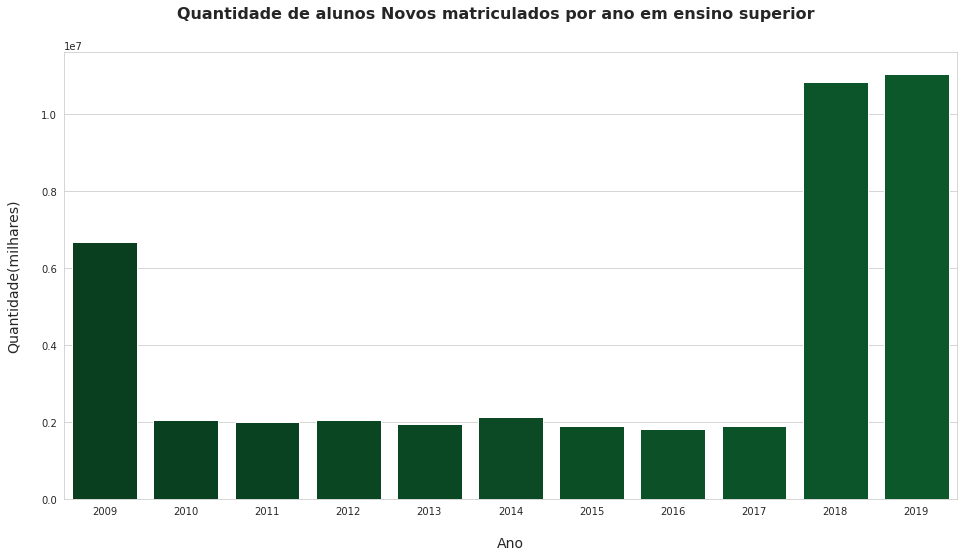

In [ ]:
titulo = "Quantidade de alunos Novos matriculados por ano em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade(milhares)"
eixoX = anos
eixoY = serie_estudantes
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Vemos que 2009 tem um numero muito grande de novos ingressantes pois é onde nossa dataset começa, então todos os alunos são contabilizados. Após este ano, temos uma constancia de pelo menos 200 mil alunos entrando por ano até um salto em 2018 e 2019 que se deve a mudança de nomeclatura ocorrida neste anos no nosso dataset, fazendo com que alunos  sejam contabilizados duas  ou até 3 vezes.

Vamos fazer o mesmo, mas agora para apenas população que se declara Negro("Cor" =2 )

In [ ]:
data_negro =data[data["Cor/Raca"] == 2]
serie_negro =data_negro.groupby(["Ano"])["Cor/Raca"].count().values
serie_negro = serie_negro[1:]

In [ ]:
# É importante notar que não existem nos dados que coletei numero de Negros em 2009( algum erro no calculo), logo pegaremos apenas dados de 2010 pra frente
anos_negro = anos[1:]


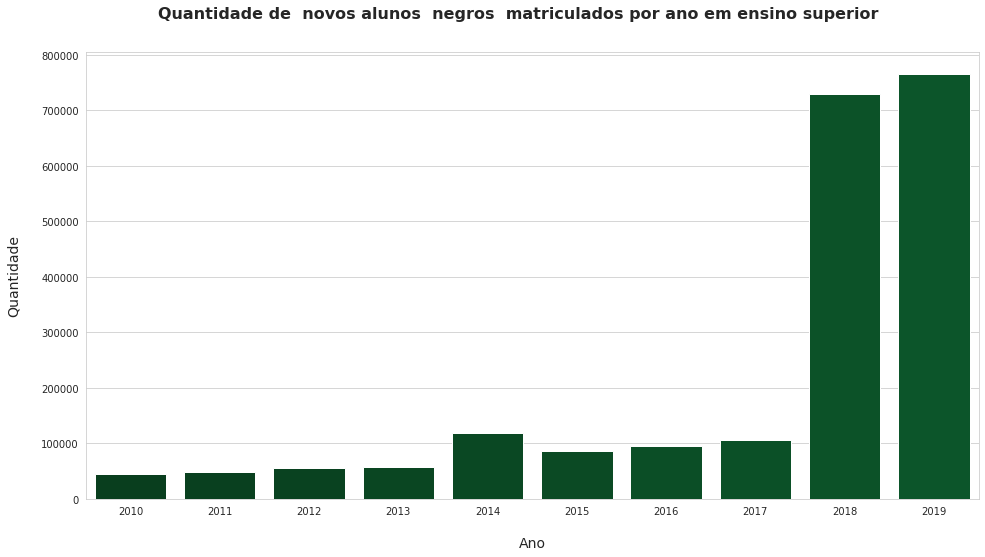

In [ ]:
titulo = "Quantidade de  novos alunos  negros  matriculados por ano em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade"
eixoX = anos_negro
eixoY = serie_negro
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Olhando para estes gráficos não se tem dimensão da quantidade de negros em ensino superior em relação aos demais. Faremos um gráfico de proporção para demonstrar isto.

In [ ]:
serie_proporcao = (serie_negro/serie_estudantes[1:])*100


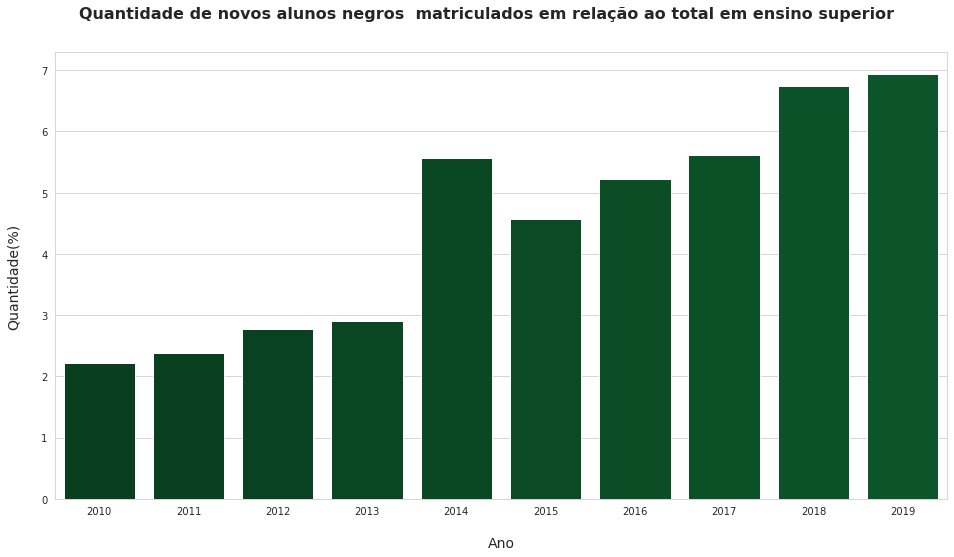

In [ ]:
titulo = "Quantidade de novos alunos negros  matriculados em relação ao total em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade(%)"
eixoX = anos_negro
eixoY = serie_proporcao
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Apenas 7% dos matriculados em 2019 são classificados negros, é um valor ínfimo em relação a sua representatividade na população. É importante notar que mesmo sendo uma porcentagem baixa, ela vem aumentando com o tempo, tendo um salto em 2014 para com os demais.Sera que a presença de cotas ajudou esse crescimento? 

### Análise cotas na população negra.

In [ ]:
data_negro_cota = data_negro[data_negro.Cota_Racial == 1].groupby(["Ano"])["Cota_Racial"].count()
serie_cota = data_negro_cota.values
serie_cota = serie_cota[1:]

In [ ]:
data.Cota_Racial.unique()

array([False,  True])

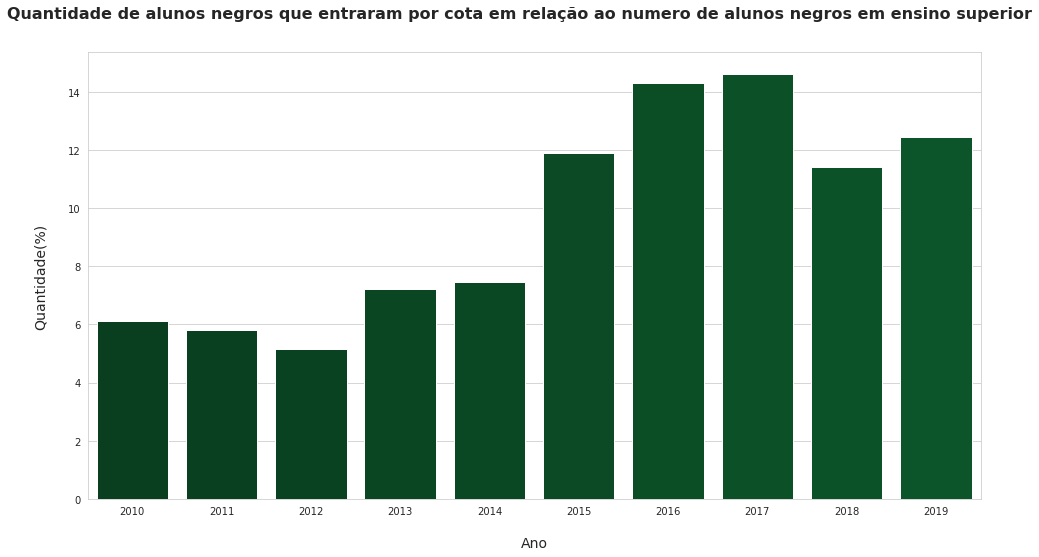

In [ ]:

titulo = "Quantidade de alunos negros que entraram por cota em relação ao numero de alunos negros em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade(%)"
eixoX = anos_negro
eixoY = (serie_cota/serie_negro)*100
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Mesmo com a utilização de cotas vemos que nem 15% dos alunos negros entraram na faculdade por este meio, entretanto o salto de 6% para 12% já é um crescimento consideravel e da importância de cotas para o aumento dessa população no ensino superior.

###Análise de presença negras em universidades Públicas e privadas.

Outra análise se refere ao número de negros em universidades públicas e privadas. Vamos ver como se comporta

In [ ]:
data_negro_publi = data_negro[(data_negro["Cat_Adm"].isin([1,2,3]))]
serie_negro_publi = data_negro_publi.groupby("Ano")["Cat_Adm"].count().values
            

In [ ]:
serie_negro_priv_outros = serie_negro - serie_negro_publi[1:]


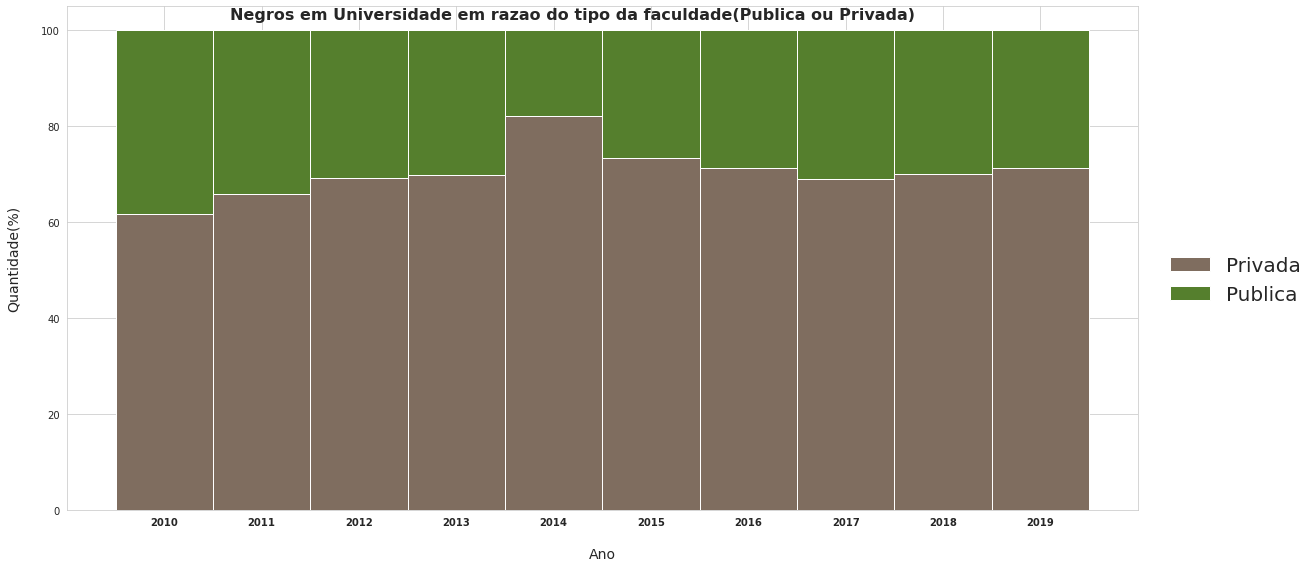

In [ ]:
import numpy as np
bars1 = (serie_negro_priv_outros/(serie_negro_priv_outros+serie_negro_publi[1:]))*100
bars2 = (serie_negro_publi[1:]/(serie_negro_priv_outros+serie_negro_publi[1:]))*100
 

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.90)
fig.suptitle("Negros em Universidade em razao do tipo da faculdade(Publica ou Privada)", fontsize=16, fontweight='bold')
ax.set_xlabel("Ano",fontsize=14, labelpad=20)
ax.set_ylabel("Quantidade(%)",fontsize=14, labelpad=20)
bars = np.add(bars1, bars2).tolist()

r = anos_negro
 
names = anos_negro
barWidth = 1
 
plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth)

 

plt.xticks(r, names, fontweight='bold')
fig.legend(["Privada","Publica"],
           loc='center left',fontsize = 20,frameon = False,bbox_to_anchor=(1, 0.5))

fig.tight_layout() 
# Show graphic
plt.show()

Vemos aqui que a maioria de alunos negros matriculados está em universisade privadas.


### Análise por Sexo.

Vamos fazer uma anáálise da Presença por Sexo total e depois por estado dividido em regiões do Brasil. Os dados para Genêro são divididos em 0 e 1 até 2016 e 1 e 2 em 2017. Por sorte temos que todos os gêneros identificados como 1 são Masculinos. Vamos transformar então 2 em 0 em cada coluna para ter apenas dois valores e ver a porcentagem de presença Masculina e Feminina total.

In [ ]:
ds = data.copy()
ds.Genero= ds.Genero.replace([2],0)

ds.Genero.value_counts(normalize = True)


1    0.566384
0    0.433616
Name: Genero, dtype: float64

Temos Uma presença maior feminina na graduação(56%), o que me supreendi a principio. Vamos analisar por Região e agrupar por estados. Para isto vamos criar a coluna Região em nosso dataset. Vamos também fazer os grafíícos utilizando subplots. Vamos então fazer uma função para nos auxiliar


In [ ]:
#@title  Criando Dícionário para regiões

dict_estados_regioes = {"PR" : "Sul",      
                        "ES" : "Sudeste",
                        "SP" : "Sudeste",
                        "PE" : "Nordeste" ,
                        "RS" : "Sul",
                        "MA" : "Centro Oeste",
                        "MS" : "Centro Oeste",
                        "RJ" : "Sudeste",
                        "CE" : "Nordeste", 
                        "DF" : "Centro Oeste",
                        "SC" : "Sul",
                        "TO" : "Norte",     
                        "PA" : "Norte",
                        "MG" : "Sudeste",
                        "BA" : "Nordeste",
                        "AM" : "Norte",
                        "SE" : "Nordeste",
                        "GO" : "Centro Oeste",
                        "RN" : "Nordeste",
                        "AP"  : "Norte",
                        "RO" : "Norte",
                        "PI" : "Nordeste",
                        "PB" : "Nordeste",
                        "AC" : "Norte",
                        "AL" : "Nordeste",
                        "RR" : "Norte"
}
     
  

Criando a coluna região 



In [ ]:
a= ds.UF.map(dict_estados_regioes)
ds["REGIAO"] = a

Criando a função que fara o grafico e ira separa-los por região.

In [ ]:
def func(dataset,serie,comparador,label,colors):

  datasGraph = [] 
  reg = ["Norte","Nordeste","Centro Oeste","Sudeste","Sul"]

  for number in range(len(reg)) :
    dataEstado = dataset[dataset.REGIAO == reg[number]]
    a = dataEstado.groupby("UF")[serie].value_counts(normalize = True,sort = False)
    datasGraph.append((a.unstack(level = 1))*100)   
  labels =label
  fig, axes= plt.subplots(5,1, figsize=(35,35))
  fig.suptitle(f'Presença de alunos de acordo com seu {comparador} por estado',fontsize = 30,y = 0.92)
  for number in range(len(reg)) :
    l1 = datasGraph[number].plot(kind = "bar",ax = axes[number],color=colors)
    axes[number].set_title(f'Regiao {reg[number]}',fontsize = 20)
    axes[number].set_xlabel("", fontsize=22)
    axes[number].tick_params(rotation=0,labelsize = 20)
    axes[number].legend("")
    axes[number].set_facecolor('lightgrey')
  fig.legend( labels, loc = 'center right',fontsize = 20,frameon = False)

  plt.show()


Vamos testar a função 


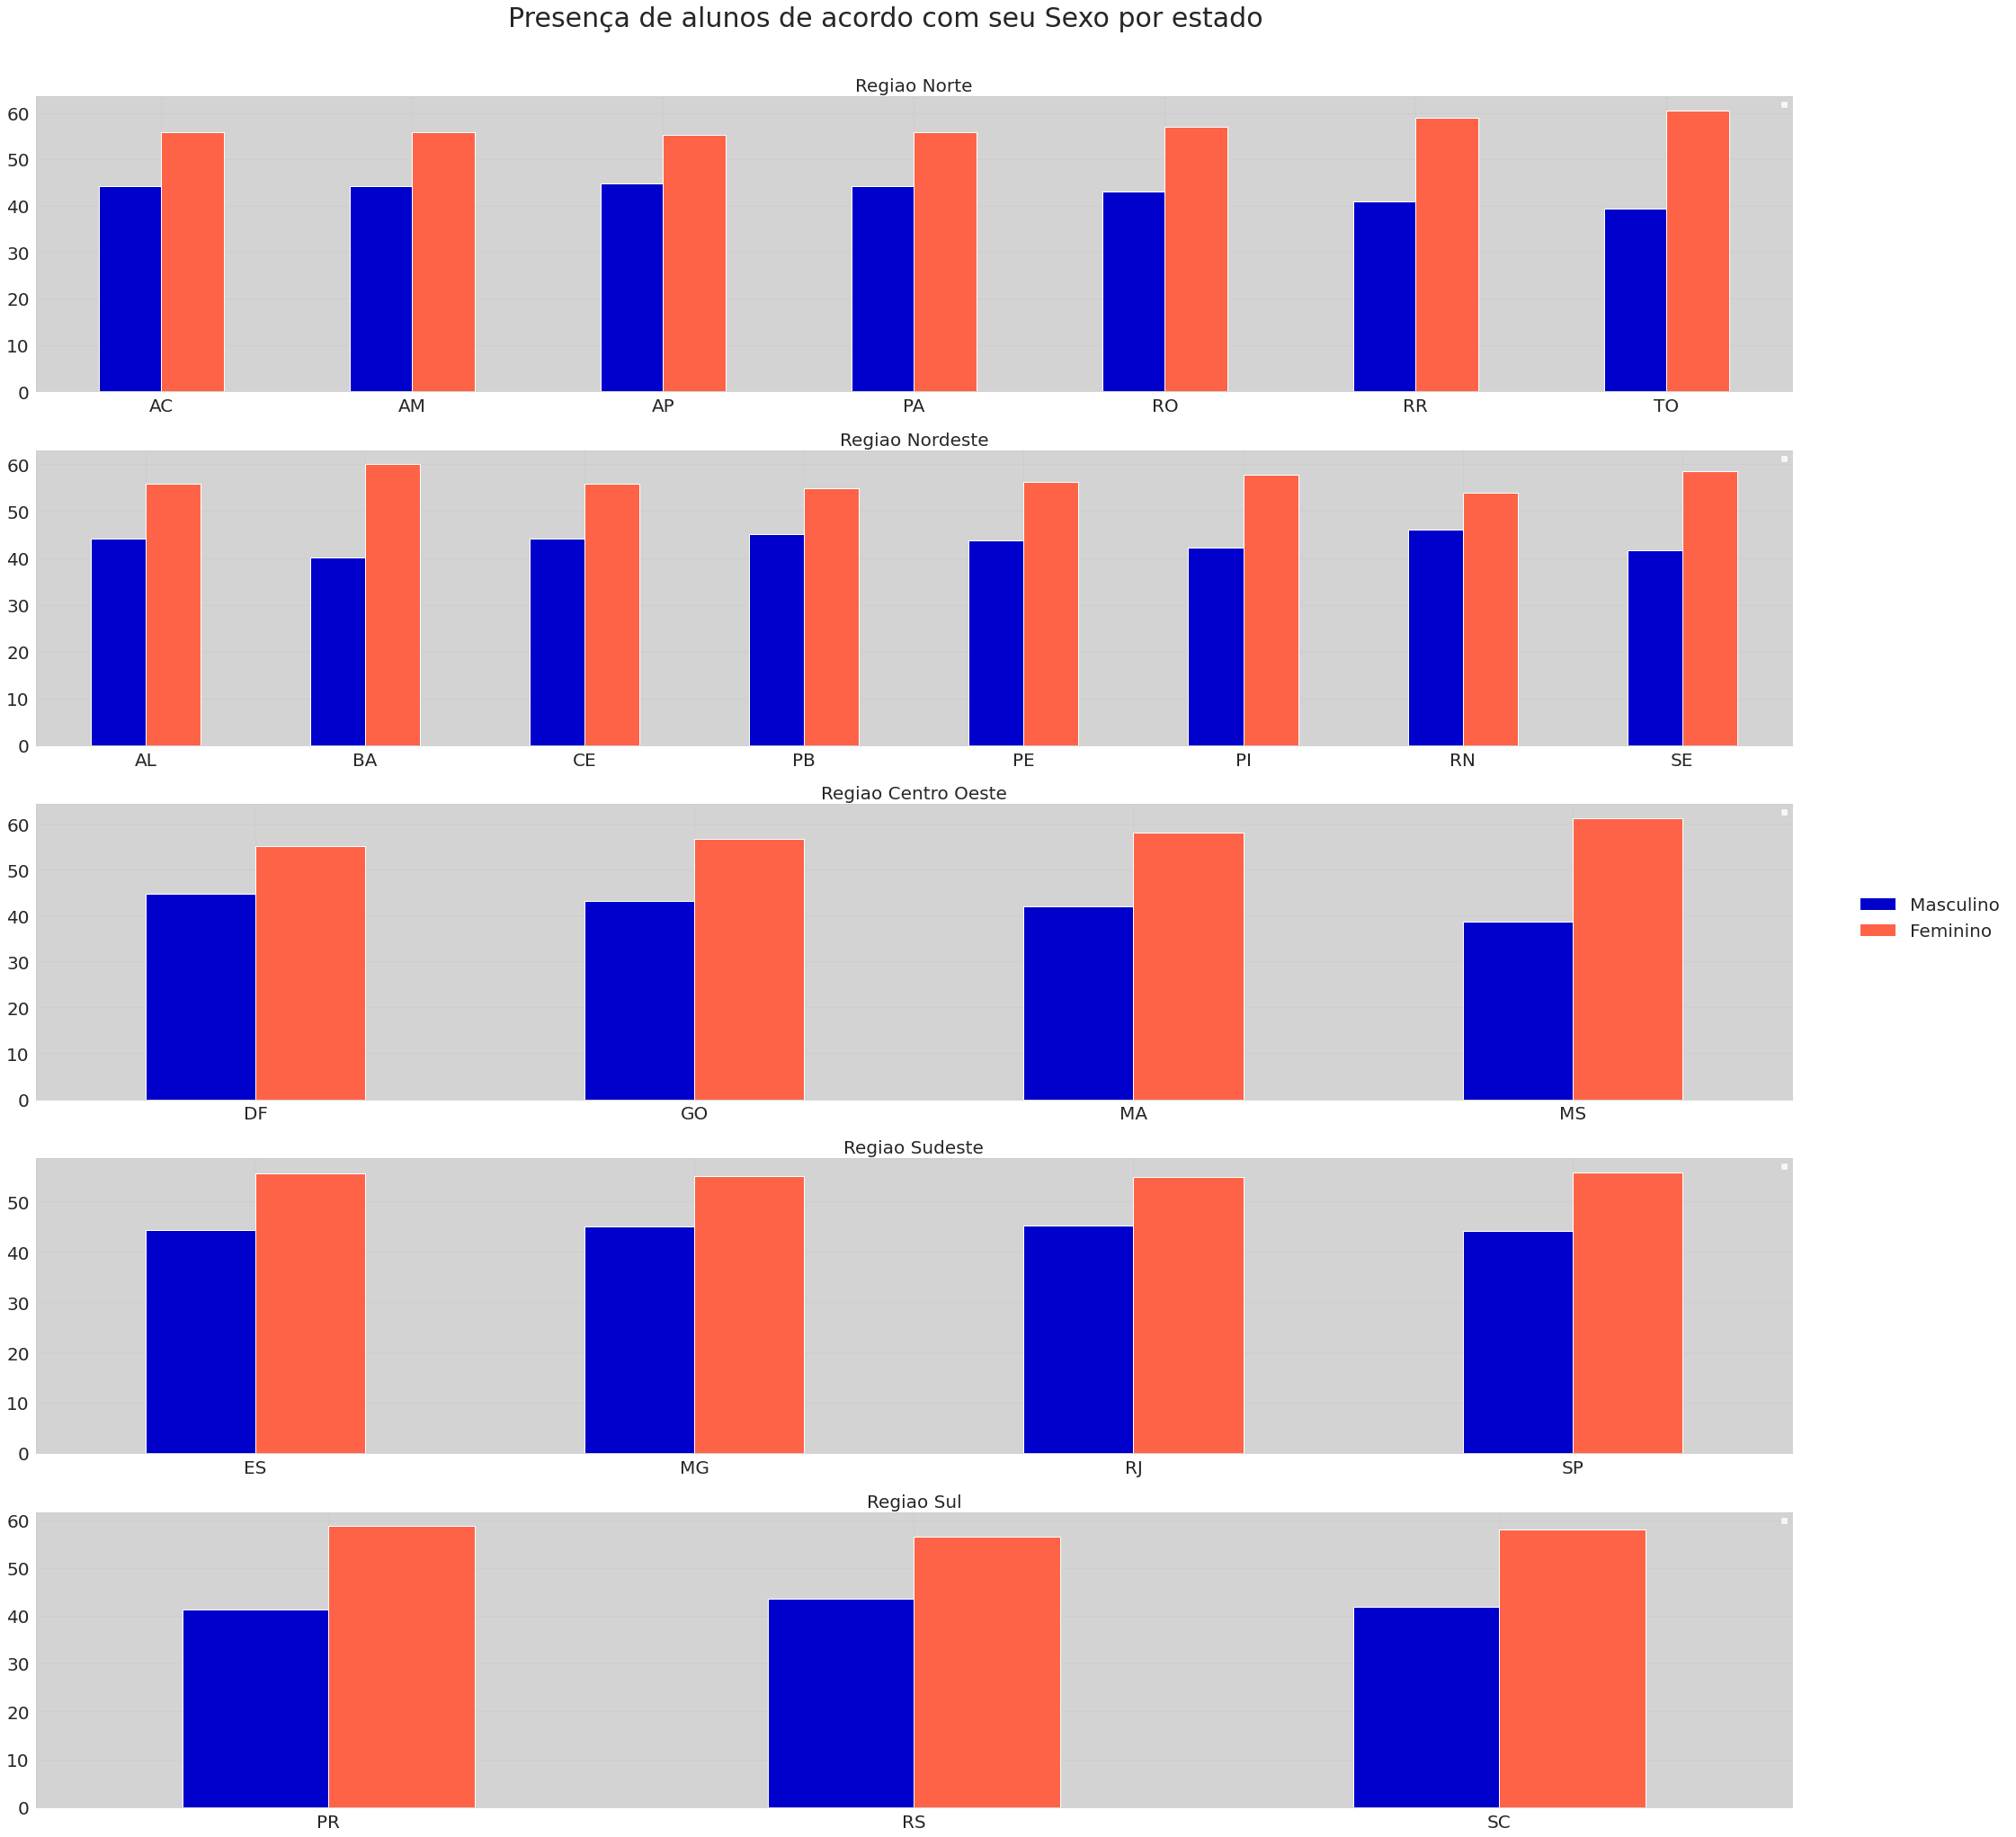

In [ ]:
dataset = ds
coluna = "Genero"
titulo = "Sexo"
label = ["Masculino","Feminino"]
color = ["mediumblue","tomato"]
func(dataset,coluna,titulo,label,color)


Vemos que temos uma constância feminina em todas as regiões, com ênfase no gap entre os sexos na região Sul.

###Analise de Cor/Raça por Região/Estado



Vamos fazer uma análise da Cor/Raça por Estado. Fizemos uma função para isto acima, podemos apenas chama-lâ com as variáveis referentes a Cor/Raça; Façamos isto. Temos no nosso dataset de cores os valores 0(Não_Declarado), 1(Branca), 2(Negro), 3(Parda),4(Amarela),5(Indigena),6(Não Informado), 9 (Não Informado).
Concatenanemos os valores 0,6,9 em Outros, para não poluir muito o gráfico e não aprender informações redudantes.

Transformando os valores

In [ ]:
da = ds.copy()
da["Cor/Raca"].unique()
da["Cor/Raca"] =da["Cor/Raca"].replace([0,9],6)


Plotando o gráfico.

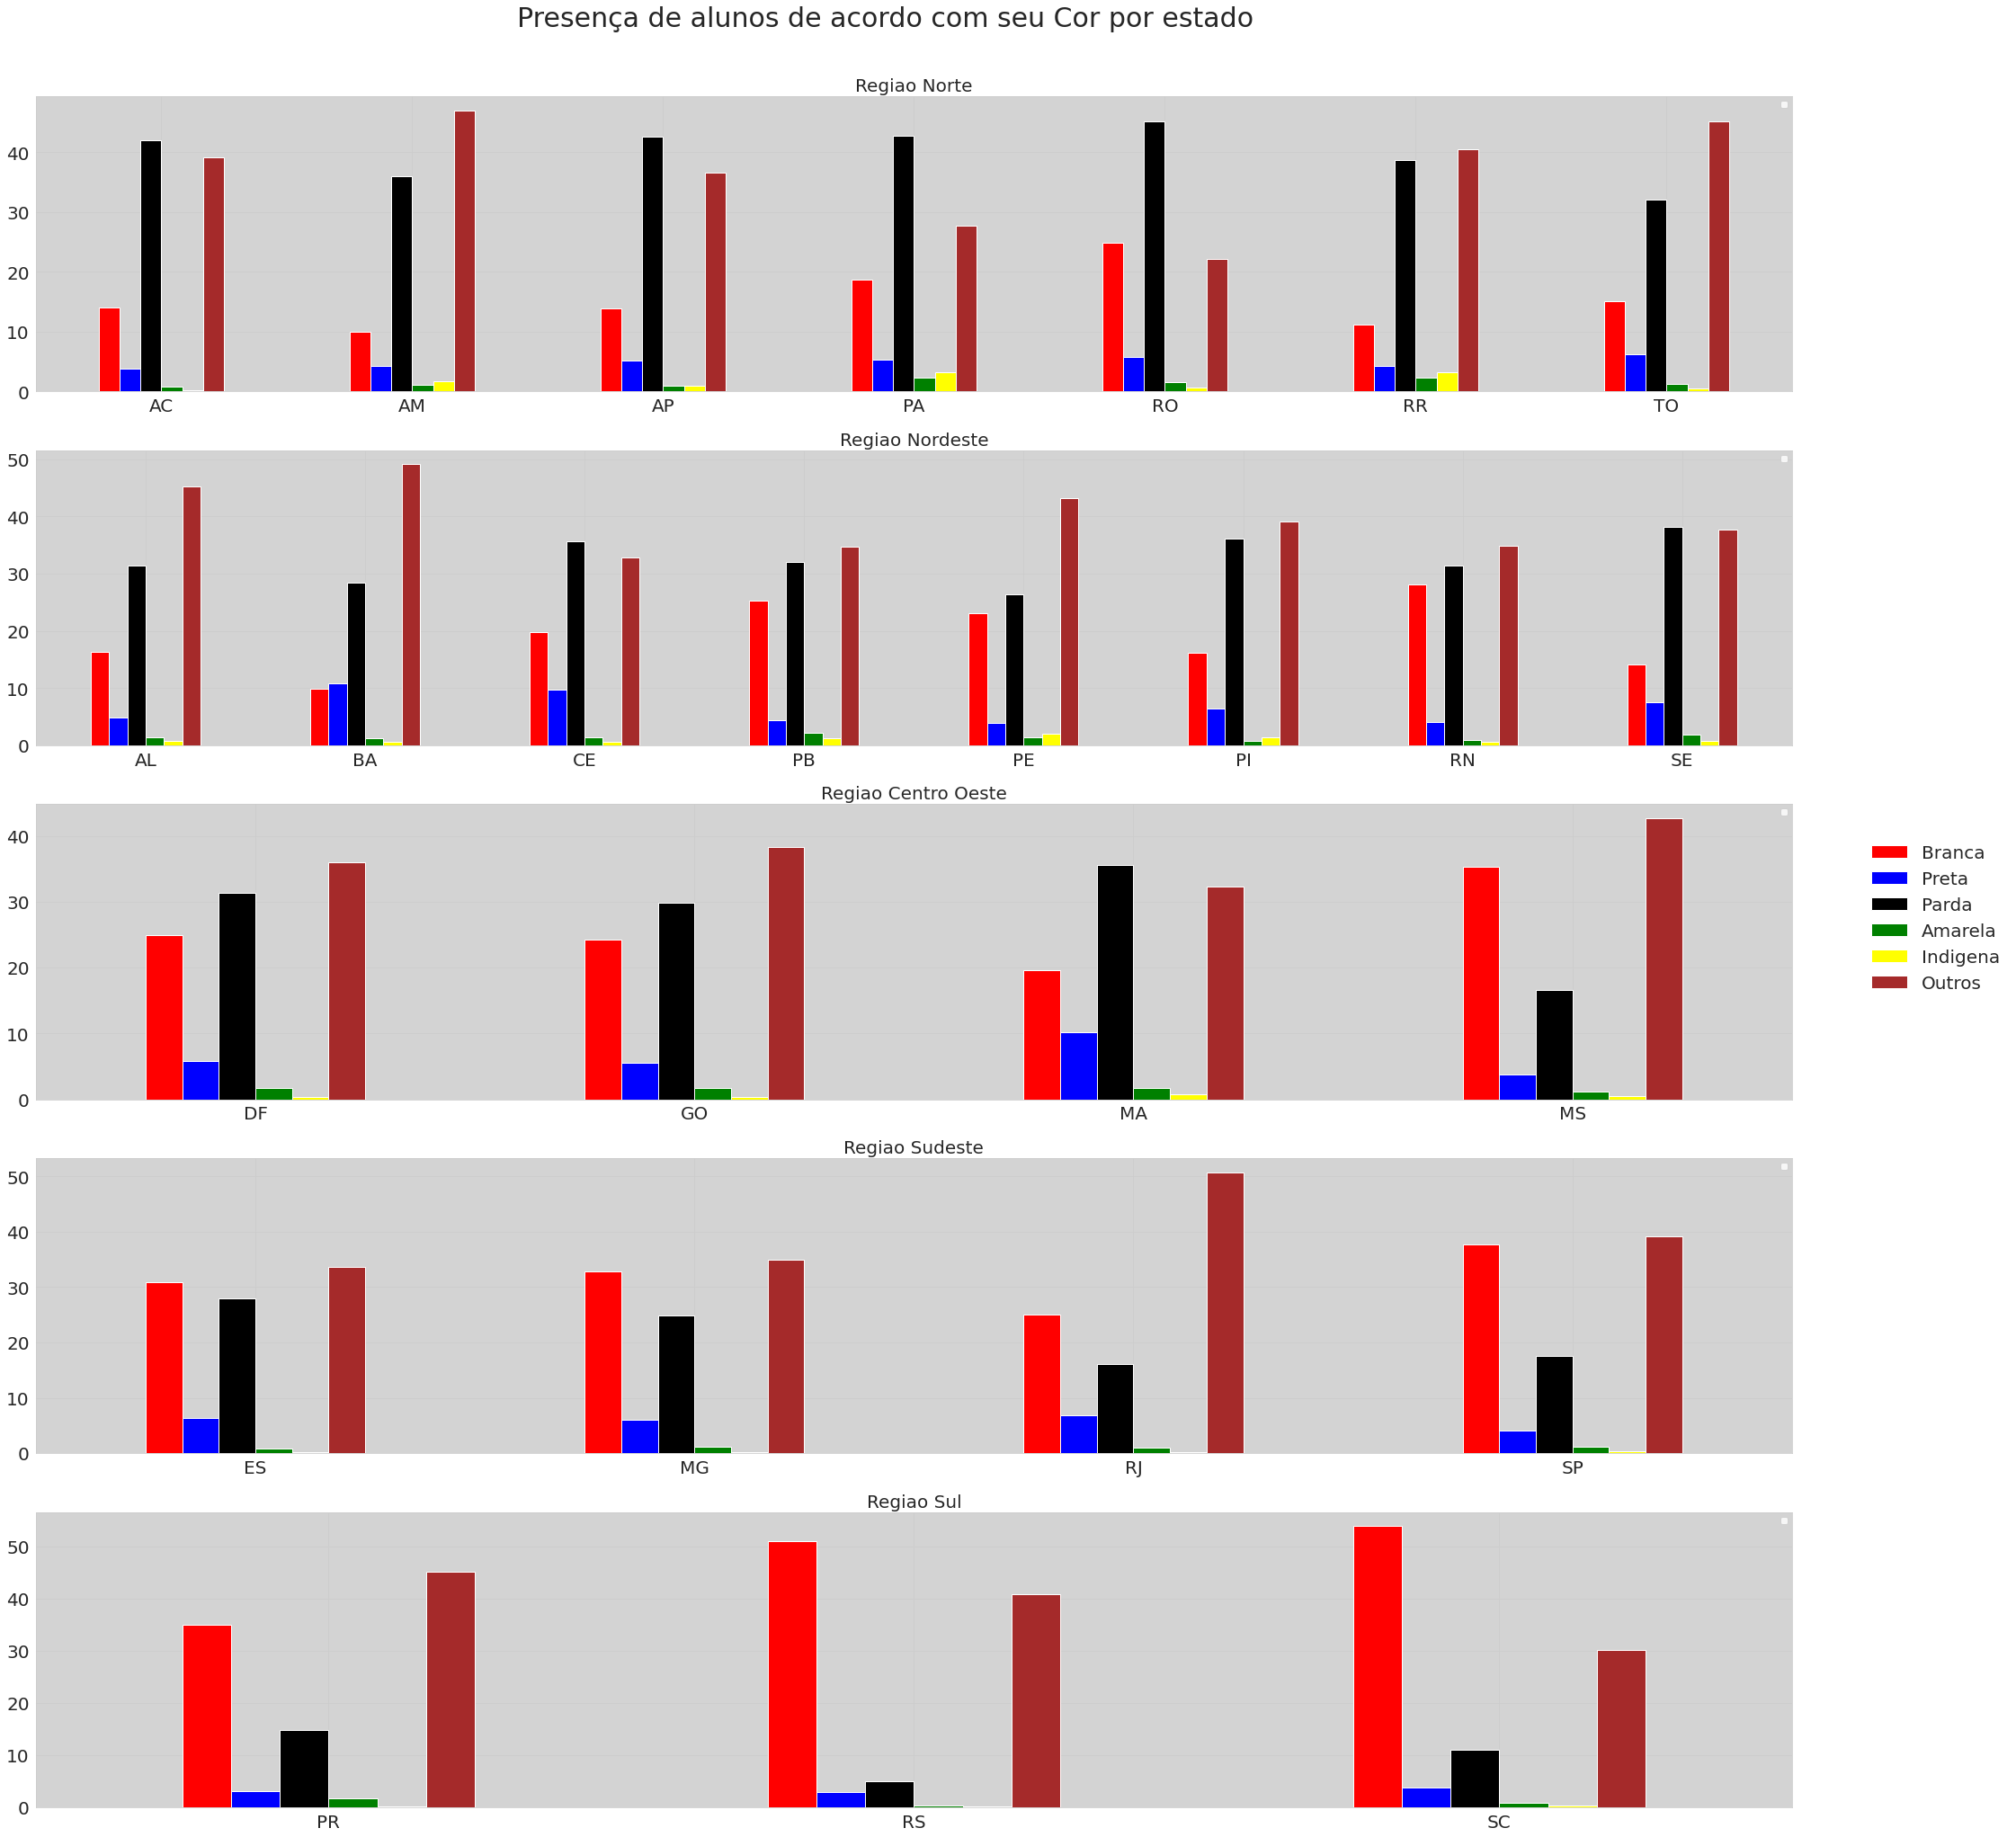

In [ ]:
dataset = da
coluna = "Cor/Raca"
titulo = "Cor"
label = ["Branca","Preta","Parda","Amarela","Indigena","Outros"]
color = ['red','blue','black','green','yellow',"brown"]
func(dataset,coluna,titulo,label,color)


Vemos que a população Parda e Negra juntas então se equiparam a população Branca na maioria das regiões. A exceção sendo a Regiãã Sul, onde a população brança é extremamente superior, principalmente Santa Catarina.